In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

# May need to update path to match local installation
import sys
sys.path.append("/home/{}/Locked-in-Leptons/helpers/".format(os.environ['USER']))
import plotting

2025-04-21 23:26:40.552735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 23:26:40.565140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 23:26:40.568715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 23:26:40.578632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 23:26:41.543058: W tensorflow/compiler/tf2

# Load the Data

In [ ]:
x_train = np.load('../data/x_train.npy')
x_test = np.load('../data/x_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

In [2]:
y_train = to_categorical(y_train,2) 
y_test = to_categorical(y_test,2)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Load the model

In [3]:
from tensorflow.keras.models import load_model

model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(x_test)

2025-04-21 23:29:55.463985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38148 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0


816341/816341 [==============================] - 569s 696us/step


## Make hls4ml config & model

In [4]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Laten

/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


# Profiling

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17

/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
   fc1
   relu1
   fc2
   relu2
   fc3
   relu3
   output
   activation


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

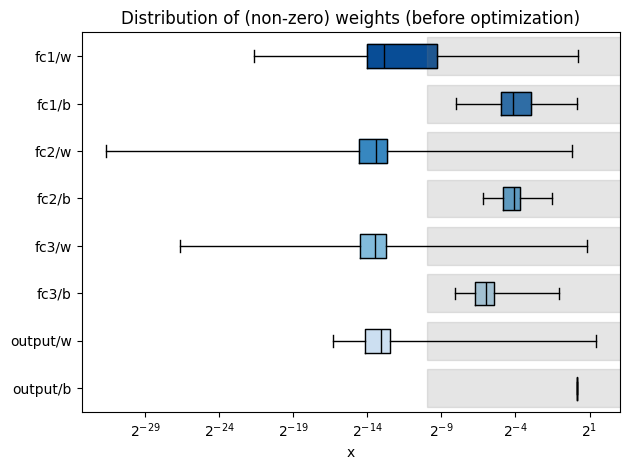

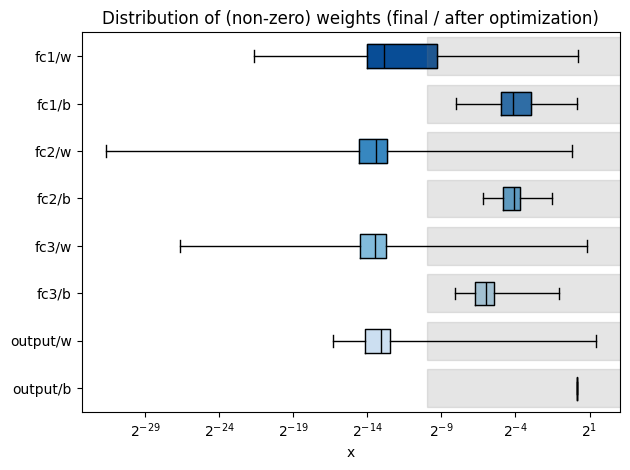

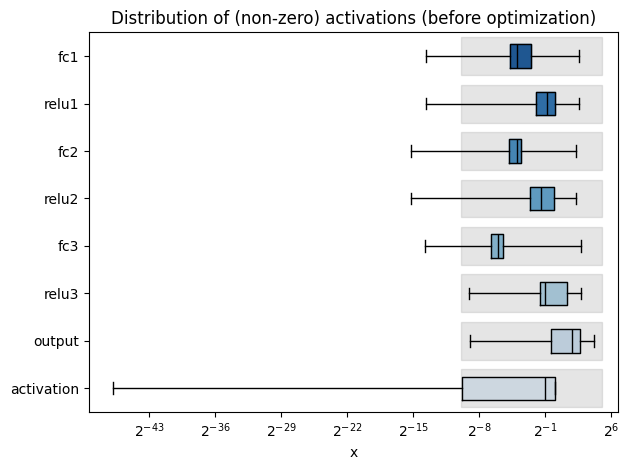

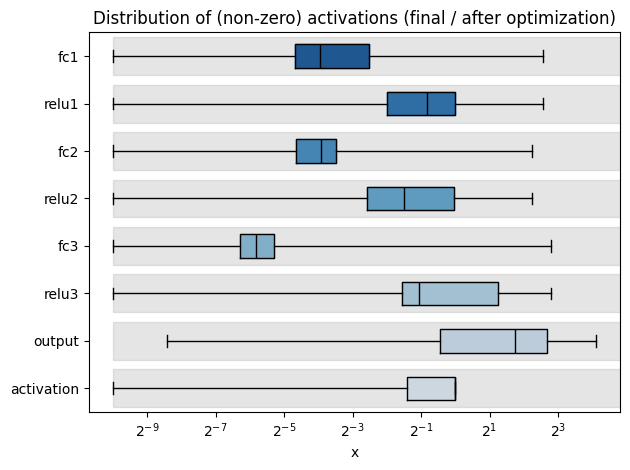

In [5]:
%matplotlib inline
from hls4ml.model.profiling import numerical, get_ymodel_keras

for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
numerical(model=model, hls_model=hls_model, X=x_test[:1000])

# Customize

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17

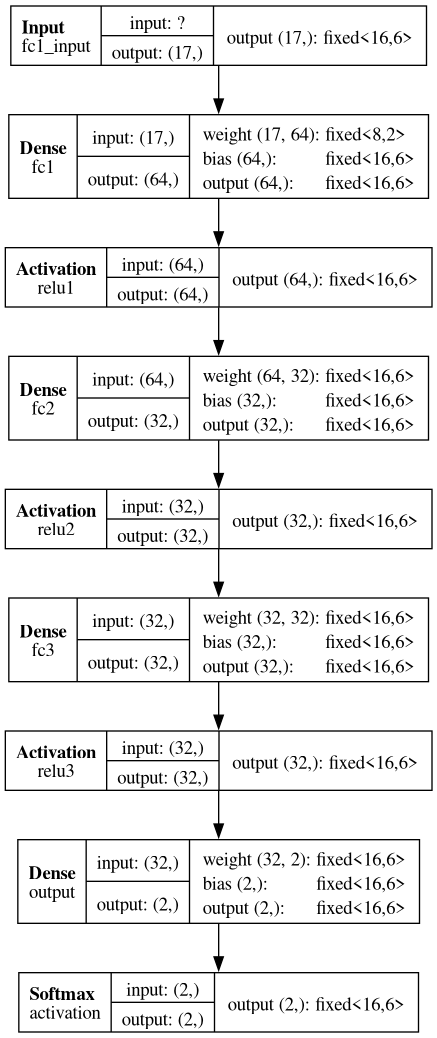

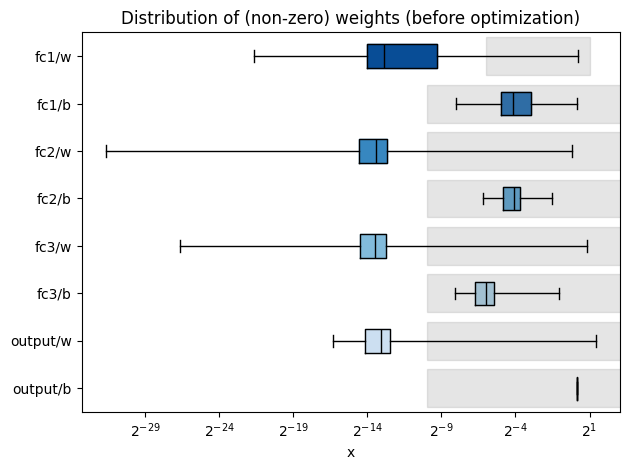

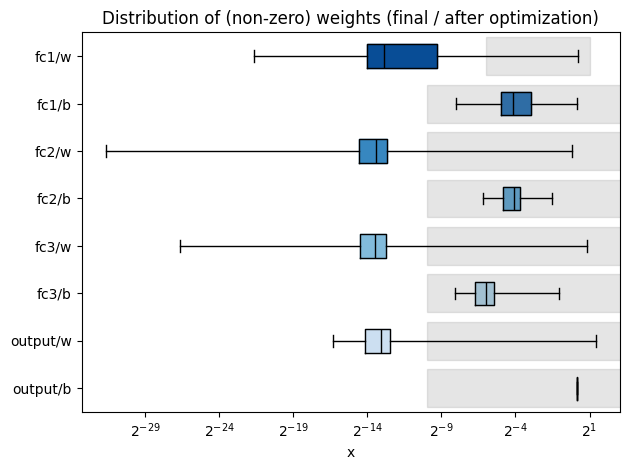

In [6]:
config['LayerName']['fc1']['Precision']['weight'] = 'ap_fixed<8,2>'
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)
numerical(model=model, hls_model=hls_model)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

# Trace

In [7]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model


# Compile, trace, predict

In [8]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(x_test[:1000])
keras_trace = get_ymodel_keras(model, x_test[:1000])
y_hls = hls_model.predict(x_test)

Writing HLS project


/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
Recompiling myproject with tracing
Writing HLS project
Done
32/32 [==============================] - 0s 907us/step
Done taking outputs for Keras model.


In [9]:
print("Keras layer 'fc1', first sample:")
print(keras_trace['fc1'][0])
print("hls4ml layer 'fc1', first sample:")
print(hls4ml_trace['fc1'][0])

Keras layer 'fc1', first sample:
[-0.04334969 -0.02406561  5.618643   -0.03924713 -0.04800108  0.32088917
 -0.7135733  -0.03312149 -0.03924885 -0.03434378  0.34822845  1.2813866
 -0.02072636 -0.06333691 -0.1827978  -0.04855619  0.37859702 -0.03193702
 -0.01942731 -0.0616306  -0.0296933  -0.07623727 -0.04175402 -0.0415221
 -0.08676994 -0.54115796  2.6429384  -0.05515224 -0.03156006 -0.02376868
 -0.07590183 -0.04907792 -1.9710139  -0.27446586 -0.02624118 -0.36704922
 -0.03174948 -0.1256806  -0.07491417  0.09402253 -0.05488747  1.7393713
 -0.15229885 -0.08091094 -0.05975684 -0.04378472 -1.921426   -0.09582049
 -3.2629275  -0.4390161   1.5244633  -0.04520218 -0.02534935 -0.01166158
 -0.06784138 -1.3555142  -0.02541343 -0.03991361 -0.09623417 -0.10807987
 -0.0365934  -0.03302575  1.646222   -0.07942931]
hls4ml layer 'fc1', first sample:
[-0.11914062 -0.15917969  5.49609375 -0.14550781 -0.23535156  0.16699219
 -0.90136719 -0.07324219 -0.19335938 -0.16503906  0.18164062  1.06835938
 -0.287109

Keras  Accuracy: 0.8920124592675143
hls4ml Accuracy: 0.8907638605293351


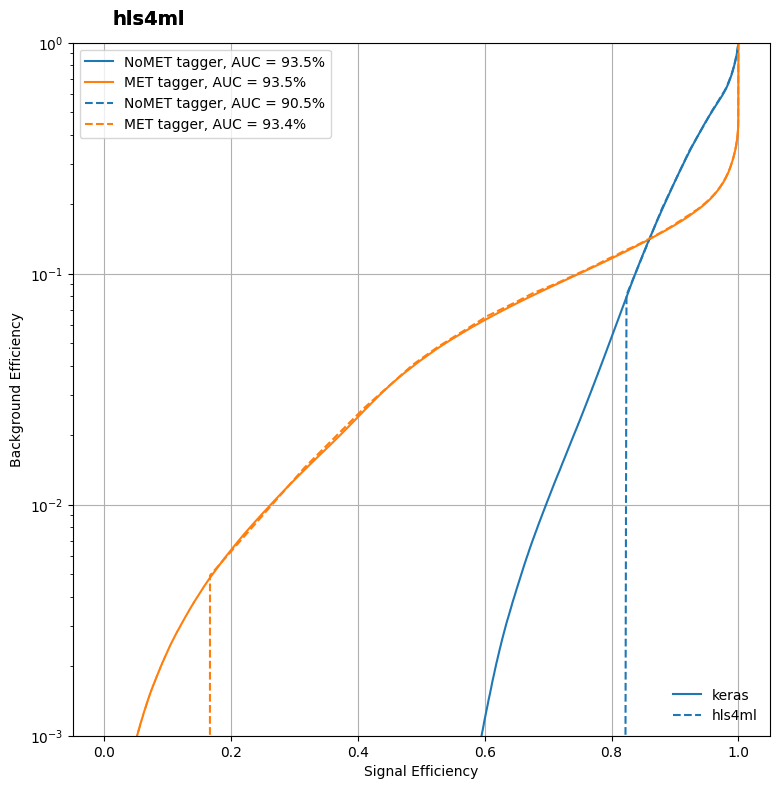

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, ["NoMET", "MET"])
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, ["NoMET", "MET"], linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

plt.savefig("plots/ROC_firstlayer.png")


In [11]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/metis/el8/contrib/amdtools/xilinx-2023.1/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/metis/el8/contrib/amdtools/xilinx-2023.1/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'frodriguez' on host 'vm01.head.cm.local' (Linux_x86_64 version 4.18.0-372.9.1.el8.x86_64) on Tue Apr 22 00:27:06 CDT 2025
INFO: [HLS 200-10] On os "Red Hat Enterprise Linux release 8.6 (Ootpa)"
INFO: [HLS 200-10] In directory '/nfs/ihfs/home_metis/frodriguez/Locked-in-Leptons/model_1/hls4ml_prj_2'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.371',
  'BestLatency': '10',
  'WorstLatency': '10',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '77',
  'FF': '5679',
  'LUT': '40670',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [12]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_2')

Found 1 solution(s) in model_1/hls4ml_prj_2/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue Apr 22 00:28:50 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.371 ns|     0.62 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------

In [18]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Apr 21 00:00:54 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.371 ns|     0.62 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------+-